In [1]:
import numpy as np
from matplotlib import pyplot as plt
from helpers import normalize_dataset

In [2]:
def one_hot_encode(labels: np.ndarray):
    '''
    one-hot encode labels
    @param labels 1D array of labels
    
    @return one-hot encoded labels
    '''
    casted_labels = labels.astype(int)
    return np.eye(np.unique(casted_labels).shape[0])[casted_labels]

def reshape_flat_square_images(images: np.ndarray):
    '''
    reshape to be a grayscale square
    @param image N x TOTAL_PIXELS

    @return N x 1 x HEIGHT x WIDTH
    '''
    dims = np.sqrt(images.shape[1])
    if not dims.is_integer():
        raise ValueError('Image is not square')
    dims = int(dims)
    return images.reshape(images.shape[0], 1, dims, dims)

In [3]:
training = np.loadtxt("dataset/train.csv",
                 delimiter=",", dtype=str) # load training data
training_labels = one_hot_encode(training[1:, 0]) # first column is labels
training_data = reshape_flat_square_images(normalize_dataset(training[1:, 1:])) # rest of columns are data

# Training Samples: 38000
# Classes: 10
Image Height: 28
Image Width: 28


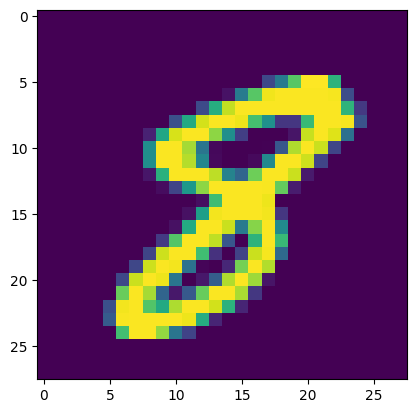

In [4]:
print("# Training Samples: " + str(training_labels.shape[0]))
print("# Classes: " + str(training_labels.shape[1]))
print("Image Height: " + str(training_data.shape[2]))
print("Image Width: " + str(training_data.shape[3]))
plt.imshow(training_data[0, 0, :, :]) # show first image in training set

In [5]:
def im2col(data: np.ndarray, conv: np.ndarray, stride: int, pad: int):
    '''
    transforms a batch of images into a matrix
    
    @param data N x 1 x HEIGHT x WIDTH input images
    @param conv NUM_FILTERS x 1 x CONV_HEIGHT x CONV_WIDTH convolutional layer
    @param stride number of pixels to move the filter each time
    @param pad number of pixels to pad the image with

    @return CONV_HEIGHT * CONV_WIDTH x NEW_WIDTH * NEW_HEIGHT * NUM_IMAGES matrix
    '''
    data_padded = np.pad(data, ((0,0), (0,0), (pad, pad), (pad, pad)), mode='constant')
    num_images, num_channels, image_height, image_width = data_padded.shape
    conv_height = conv.shape[2]
    conv_width = conv.shape[3]
    output_height = int((image_height + (2 * pad) - conv_height) / stride) + 1
    output_width = int((image_width + (2 * pad) - conv_width) / stride) + 1
    
    # create a 4D view of the padded data to extract image patches
    # view has shape (num_images, num_channels, output_height, output_width, conv_height, conv_width)
    data_view = np.lib.stride_tricks.as_strided(data_padded,
                                                shape=(num_images, num_channels, output_height, output_width, conv_height, conv_width),
                                                strides=(data_padded.strides[0], data_padded.strides[1], 
                                                         stride * data_padded.strides[2], stride * data_padded.strides[3], 
                                                         data_padded.strides[2], data_padded.strides[3]))
    
    # reshape the view to a 2D array
    # the shape of the array is (num_images * output_height * output_width, num_channels * conv_height * conv_width)
    im2col_vector = data_view.reshape(num_images * output_height * output_width, num_channels * conv_height * conv_width)
    
    return im2col_vector.T # transpose the matrix to match the expected output shape

def convolve(data: np.ndarray, im2col_result: np.ndarray, conv: np.ndarray, stride: int):
    '''
    convolves the data with the im2col result
    @param data N x 1 x HEIGHT x WIDTH input images
    @param im2col_result CONV_HEIGHT * CONV_WIDTH x NEW_WIDTH * NEW_HEIGHT * NUM_IMAGES matrix
    @param conv NUM_FILTERS x 1 x CONV_HEIGHT x CONV_WIDTH convolutional layer
    @param stride number of pixels to move the filter each time
    
    @return NUM_IMAGES x NUM_FILTERS x NEW_HEIGHT x NEW_WIDTH matrix
    '''
    num_images, _, height, width = data.shape
    num_filters, _, conv_height, conv_width = conv.shape
    new_height = int(((height - conv_height) / stride)) + 1
    new_width = int(((width - conv_width) / stride)) + 1
    
    im2col_reshaped = im2col_result.reshape(conv_height * conv_width, new_width * new_height * num_images)
    conv_reshaped = conv.reshape(num_filters, -1)
    
    output = np.empty((num_images, num_filters, new_height, new_width))
    
    for i in range(num_images):
        convolved = conv_reshaped @ im2col_reshaped[:, i * new_height * new_width:(i + 1) * new_height * new_width]
        output[i] = convolved.reshape(num_filters, new_height, new_width)
    
    return output

In [6]:
num_filters = 2
conv_filter_size = 5
conv_layer = np.random.randn(num_filters, 1, conv_filter_size, conv_filter_size) * np.sqrt(1. / conv_filter_size)
display(conv_layer.shape)

(2, 1, 5, 5)

In [7]:
conv_stride = 1
conv_pad = 0
conv_res = convolve(training_data, im2col(training_data, conv_layer, conv_stride, conv_pad), conv_layer, conv_stride)
display(conv_res.shape)

(25, 21888000)

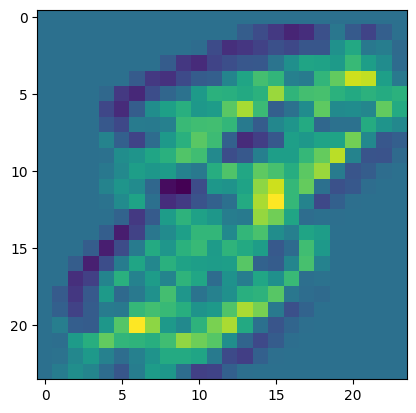

In [9]:
plt.imshow(conv_res[0, 0, :, :]) # first training image, first filter of convolutional layer